# Random Forest Imputations
Random forest worked best up to now. Up to now, We've mainly used zero imputations and a K Means imputation in a Random Forest. Let's take a look what other imputation methods would do, both for the case of one Random Forest model for the two chains together and for two Random Forest models for the two chains separately.

In [115]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from util import get_train_dataset, get_features, fix_test, evaluate
import numpy as np
from sklearn import impute

df = get_train_dataset()
# df = df.sample(n=1000)

df_reaction_column = df['reaction']
df_features = get_features(df)

df_features.reset_index(drop=True, inplace=True)
df_reaction_column.reset_index(drop=True, inplace=True)

assert df_features.shape[0] == df_reaction_column.shape[0]
assert np.isnan(df_reaction_column).sum().sum() == 0

# add the reaction column to the features (will be dropped later on)
df_features['reaction'] = df_reaction_column

In [116]:
y = df_features['reaction']
x = df_features.drop(['reaction'], axis=1)

assert 'reaction' not in x.columns
assert np.isnan(y).sum() == 0

In [117]:
# get sklearn version
from sklearn import __version__ as sklearn_version
print('The scikit-learn version is {}.'.format(sklearn_version))

The scikit-learn version is 1.1.0.


## Imputations

In [118]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)

### Simple Imputer

#### Zero Imputation

In [119]:
# zero imputation
imputer_zero = impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
x_zero_imputed = imputer_zero.fit_transform(x)

In [120]:
evaluate(clf, x_zero_imputed, y)

[0.88498462 0.88172472 0.85801867 0.87094258 0.86453068]
ROC: 0.872 (+/- 0.020)


#### Mean Imputation

In [121]:
# Mean imputation
imputer_mean = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
x_mean_imputed = imputer_mean.fit_transform(x)

In [122]:
evaluate(clf, x_mean_imputed, y)

[0.8868557  0.87375455 0.85548941 0.87100637 0.86316189]
ROC: 0.870 (+/- 0.021)


#### Most Frequent Imputation

In [123]:
# Most frequent imputation
imputer_most_frequent = impute.SimpleImputer(missing_values=np.nan, strategy='most_frequent')
x_most_frequent_imputed = imputer_most_frequent.fit_transform(x)

C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\impute\_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


In [124]:
evaluate(clf, x_most_frequent_imputed, y)

[0.88688104 0.87277267 0.86189338 0.86987404 0.86193157]
ROC: 0.871 (+/- 0.018)


#### Median Imputation

In [125]:
# Median imputation
imputer_median = impute.SimpleImputer(missing_values=np.nan, strategy='median')
x_median_imputed = imputer_median.fit_transform(x)

In [126]:
evaluate(clf, x_median_imputed, y)

[0.88096586 0.87623025 0.85571559 0.87303327 0.86051565]
ROC: 0.869 (+/- 0.019)


#### Multivariate Imputation

In [127]:
# Takes way too long

# Multivariate imputer that estimates each feature from all the others.
# A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion
# src: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

# Extra importe required: https://stackoverflow.com/questions/55846680/can-not-import-iterativeimputer-from-sklearn-impute
from sklearn.experimental import enable_iterative_imputer

# imputer = impute.IterativeImputer(max_iter=10, random_state=0)
# x_iterative_imputed = imputer.fit_transform(x)

In [128]:
# evaluate(clf, x_iterative_imputed, y)

## Missing Indicator

In [129]:
# Note: It's important to create the missing indication based on df and not the features generated out of it, since the features will always have missing values (because of the positional features)
df.head()

,CDR3_alfa,TRAV,TRAJ,CDR3_beta,TRBV,TRBJ,reaction
0,CAMKSTNAGKSTF,TRAV12-3,TRAJ27,CASSLGVAGTNTGELFF,TRBV11-2,TRBJ2-2,1
1,CAENPYSSASKIIF,TRAV13-2,TRAJ3,CASRGTTNNEQFF,TRBV4-1,TRBJ2-1,0
2,NaN,NaN,NaN,CASSQACRGRHRNTIYF,TRBV3-1,TRBJ1-3,1
3,CAYDFPQGGSEKLVF,TRAV38-2DV8,TRAJ57,CSAPGRRGENTIYF,TRBV20-1,TRBJ1-3,0
4,NaN,NaN,NaN,CASSIRSTGELFF,TRBV19,TRBJ2-2,1


In [130]:
# Do a constant 0 imputation, but add an indicator whether the sample contained any missing value or not
# Create a vector representing whether a row has a missing value or not
missing_indicator = impute.MissingIndicator(missing_values=np.nan)
missing_indicator.fit_transform(df)[:5]

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [ True,  True,  True, False, False, False],
       [False, False, False, False, False, False],
       [ True,  True,  True, False, False, False]])

In [131]:
# replace each row in missing_indicator with it's "any" value
x_any_missing = missing_indicator.transform(df).any(axis=1)
x_any_missing[:5]

array([False, False,  True, False,  True])

In [132]:
# Create a copy of x
x_missing_indicator = x.copy()
assert x_missing_indicator.shape[0] == x_any_missing.shape[0]

In [133]:
# Add a column to x_missing_indicator with the missing indicator
x_missing_indicator['any_missing'] = x_any_missing

In [134]:
x_missing_indicator

,beta_J,beta_J=TRBJ1-1,beta_J=TRBJ1-2,beta_J=TRBJ1-3,beta_J=TRBJ1-4,beta_J=TRBJ1-5,beta_J=TRBJ1-6,beta_J=TRBJ2-1,beta_J=TRBJ2-2,beta_J=TRBJ2-3,...,alfa_pos_8_pI,alfa_pos_-9_pI,alfa_pos_9_pI,alfa_pos_-10_pI,alfa_pos_10_pI,alfa_pos_-11_pI,alfa_pos_11_pI,alfa_pos_-12_pI,alfa_pos_12_pI,any_missing
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8302,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
8303,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
8304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
8305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [135]:
imputer_zero = impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
x_zero_imputed_and_missing_indicator = imputer_zero.fit_transform(x_missing_indicator)

In [136]:
evaluate(clf, x_zero_imputed_and_missing_indicator, y)

[0.88534667 0.88083263 0.86348532 0.87373138 0.86764454]
ROC: 0.874 (+/- 0.016)


## Test set without missing values

In [137]:
from sklearn.model_selection import train_test_split
from util import get_train_dataset, get_features, fix_test, evaluate, calculate_auc_and_plot

df = get_train_dataset()
# df = df.sample(n=1000) # for faster debugging

train, test = train_test_split(df, test_size=0.2, random_state=42)

test.dropna(inplace=True)

In [138]:
x = get_features(train)
y = train['reaction']

In [139]:
x_test = get_features(test, test=True)
x_test  = fix_test(x_test, x.columns)
y_test = test['reaction']

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


In [140]:
clf = RandomForestClassifier(random_state=0)

In [141]:
def evaluate_imputer(imputer):
    x_imputed = imputer.fit_transform(x)
    clf.fit(x_imputed, y)
    x_test_imputed = imputer.transform(x_test)
    y_pred = clf.predict_proba(x_test_imputed)[:, 1]
    auc = calculate_auc_and_plot(y_test, y_pred)
    print(f'AUC: {auc:.3f}')

In [142]:
def get_columns_starting_with(df, prefix):
    return df[df.columns[df.columns.str.startswith(prefix)]]

In [143]:
clf1 = RandomForestClassifier(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
def evaluate_imputer_seperate_chains(imputer1, imputer2):
    # Keep only the columns starting with 'alfa_'
    x_alpha = get_columns_starting_with(x, 'alfa_')
    x_beta = get_columns_starting_with(x, 'beta_')

    x_imputed_alpha = imputer1.fit_transform(x_alpha)
    x_imputed_beta = imputer2.fit_transform(x_beta)

    clf1.fit(x_imputed_alpha, y)
    clf2.fit(x_imputed_beta, y)

    x_test_alpha = get_columns_starting_with(x_test, 'alfa_')
    x_test_beta = get_columns_starting_with(x_test, 'beta_')

    x_test_alpha = fix_test(x_test_alpha, x_alpha.columns)
    x_test_beta = fix_test(x_test_beta, x_beta.columns)

    x_test_imputed_alpha = imputer1.transform(x_test_alpha)
    x_test_imputed_beta = imputer2.transform(x_test_beta)

    y_pred1 = clf1.predict_proba(x_test_imputed_alpha)[:, 1]
    y_pred2 = clf2.predict_proba(x_test_imputed_beta)[:, 1]

    y_pred = (y_pred1 + y_pred2) / 2
    auc = calculate_auc_and_plot(y_test, y_pred)

    print(f'AUC: {auc:.3f}')

### Zero Imputation

In [144]:
# Zero imputation
imputer_zero = impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
imputer_zero2 = impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)

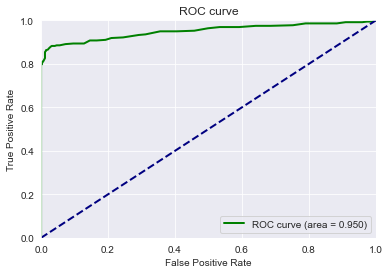

AUC: 0.950


In [145]:
evaluate_imputer(imputer_zero)

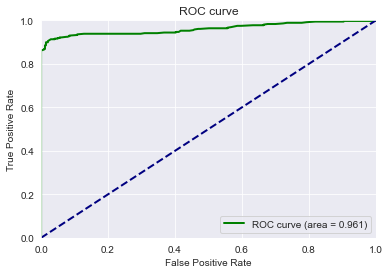

AUC: 0.961


In [146]:
evaluate_imputer_seperate_chains(imputer_zero, imputer_zero2)

In [147]:
# Mean imputation
imputer_mean = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_mean2 = impute.SimpleImputer(missing_values=np.nan, strategy='mean')

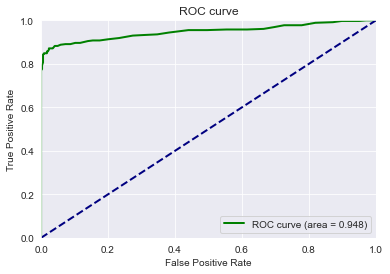

AUC: 0.948


In [148]:
evaluate_imputer(imputer_mean)

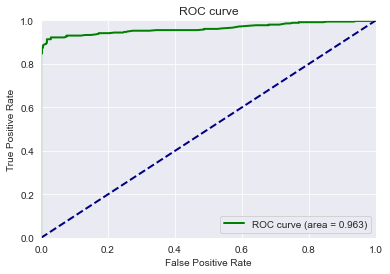

AUC: 0.963


In [149]:
evaluate_imputer_seperate_chains(imputer_mean, imputer_mean2)

C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\impute\_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


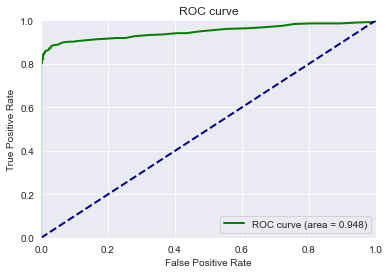

AUC: 0.948


In [150]:
# Most frequent imputation
imputer_most_frequent = impute.SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer_most_frequent2 = impute.SimpleImputer(missing_values=np.nan, strategy='most_frequent')
evaluate_imputer(imputer_most_frequent)

C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\impute\_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)
C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\impute\_base.py:54: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or 

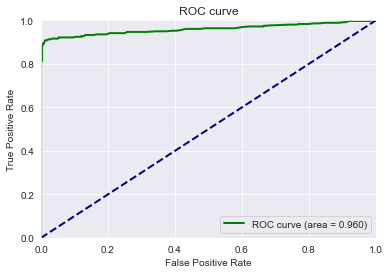

AUC: 0.960


In [151]:
evaluate_imputer_seperate_chains(imputer_most_frequent, imputer_most_frequent2)

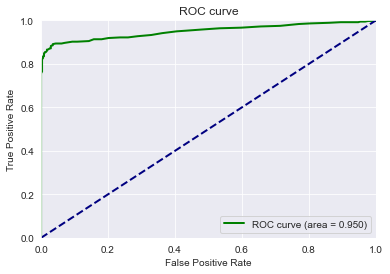

AUC: 0.950


In [152]:
# Median imputation
imputer_median = impute.SimpleImputer(missing_values=np.nan, strategy='median')
imputer_median2 = impute.SimpleImputer(missing_values=np.nan, strategy='median')
evaluate_imputer(imputer_median)

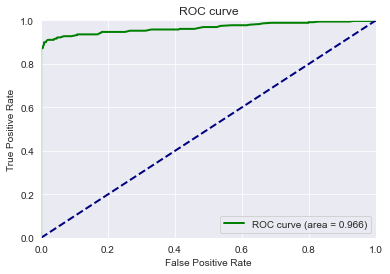

AUC: 0.966


In [153]:
evaluate_imputer_seperate_chains(imputer_median, imputer_median2)

### Missing Indicator

In [154]:
missing_indicator = impute.MissingIndicator(missing_values=np.nan)
x_any_missing_train = missing_indicator.fit_transform(train).any(axis=1)
x_any_missing_test = missing_indicator.transform(test).any(axis=1)
assert x_any_missing_train.shape[0] == x.shape[0]
assert x_any_missing_test.shape[0] == x_test.shape[0]

In [155]:
x_missing_indicator = x.copy()
x_missing_indicator_test = x_test.copy()

# Add a column to x_missing_indicator with the missing indicator
x_missing_indicator['any_missing'] = x_any_missing_train
x_missing_indicator_test['any_missing'] = x_any_missing_test

In [156]:
imputer_zero = impute.SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
x_zero_imputed_and_missing_indicator = imputer_zero.fit_transform(x_missing_indicator)
x_zero_imputed_and_missing_indicator_test = imputer_zero.transform(x_missing_indicator_test)

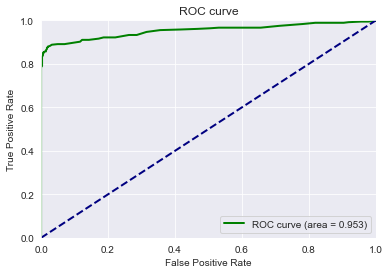

AUC: 0.953


In [157]:
clf.fit(x_zero_imputed_and_missing_indicator, y)
y_pred = clf.predict_proba(x_zero_imputed_and_missing_indicator_test)[:, 1]
auc = calculate_auc_and_plot(y_test, y_pred)
print(f'AUC: {auc:.3f}')